In [1]:
import torch 
import torch.nn as nn
from torch.optim import SGD
from torch.functional import F
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision
from torchvision import datasets, transforms
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np


Preparando o Dataset MNIST

In [2]:

mnist_trainset = datasets.MNIST(root=r"C:\Users\Felipe\Desktop\Projetos Pessoais\MNIST",
                                train=True, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

mnist_testset = datasets.MNIST(root=r"C:\Users\Felipe\Desktop\Projetos Pessoais\MNIST", 
                               train=False, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))



Modelo autoencoder: A camada de encoder recebe uma imagem 28x28 comprimida em um vetor 784 e retorna uma distribuição debtro do espaço latente   

In [7]:
class Vautoencoder(nn.Module):
    def __init__(self,input_dim, h_dim, z_dim):
        super().__init__()
        #Camadas do encoder 
        self.camada_entrada = nn.Linear(input_dim,h_dim)
        self.camada_extra = nn.Linear(h_dim,100)
        self.entrada_2mu = nn.Linear(100, z_dim)
        self.entrada_2sigma = nn.Linear(100, z_dim)
        #Camadas do decoder
        self.z_2hiden = nn.Linear(z_dim,100)
        self.camada_extra2 = nn.Linear(100,h_dim)
        self.hid_2img = nn.Linear(h_dim,input_dim)
        
        self.relu = nn.ReLU()
        
    def encode(self,x):
        h = self.relu(self.camada_entrada(x))
        h = self.relu(self.camada_extra(h))
        mu = self.entrada_2mu(h)
        sigma = self.entrada_2sigma(h)
        return mu, sigma
        
    def decode(self,z):
        h = self.relu(self.z_2hiden(z))
        h = self.relu(self.camada_extra2(h))
        return torch.sigmoid(self.hid_2img(h))
        
        
    def forward(self,x):
        mu, sigma = self.encode(x)
        epsilon = torch.rand_like(sigma)
        z_reparametrizado = mu + sigma*epsilon
        x_reconstruido = self.decode(z_reparametrizado)
        return x_reconstruido, mu, sigma
        

## Configurações 

In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMPUT_DIM = 784
H_DIM = 500
Z_DIM = 20
NUM_EPOCH = 15
LA_RATE = 3e-4
BATCH_SIZE = 32



In [9]:
#train_data = MnistDataset(X)
train_dl = DataLoader(mnist_trainset,batch_size= BATCH_SIZE)
model = Vautoencoder(IMPUT_DIM,H_DIM,Z_DIM).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(),lr=LA_RATE)
loss_func = nn.MSELoss()
loss_per_epoch = np.zeros(NUM_EPOCH)


In [10]:
def train_network(model,train_dl,optimizer,loss_func,NUM_EPOCH,DEVICE,loss_per_epoch):
    for epoch in range(NUM_EPOCH):
        for  _, (X,y) in enumerate(train_dl):
            
            x = X.to(DEVICE).view(X.shape[0],IMPUT_DIM)
            x_reconstructed, mu, sigma = model(x)

        
            recons_loss= loss_func(x_reconstructed,x) 
           
            
            kl_div = -0.5*torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

            optimizer.zero_grad() 
            loss_val = recons_loss + kl_div
            loss_val.backward()
            optimizer.step()
          

            loss_per_epoch[epoch] = loss_val 

        
        print(f"Epoch {epoch}, Erro Treino: {loss_per_epoch[epoch]}")
    

In [11]:
train_network(model,train_dl,optimizer,loss_func,NUM_EPOCH,DEVICE,loss_per_epoch)

Epoch 0, Erro Treino: 1.4881840944290161
Epoch 1, Erro Treino: 1.014314889907837
Epoch 2, Erro Treino: 0.9178872108459473
Epoch 3, Erro Treino: 0.8431979417800903
Epoch 4, Erro Treino: 0.8399469256401062
Epoch 5, Erro Treino: 0.8269068002700806
Epoch 6, Erro Treino: 0.8678863048553467
Epoch 7, Erro Treino: 0.8101601600646973
Epoch 8, Erro Treino: 0.7988297939300537
Epoch 9, Erro Treino: 0.7854621410369873
Epoch 10, Erro Treino: 0.7866432666778564
Epoch 11, Erro Treino: 0.7821935415267944
Epoch 12, Erro Treino: 0.7806083559989929
Epoch 13, Erro Treino: 0.7931733131408691
Epoch 14, Erro Treino: 0.7791171073913574


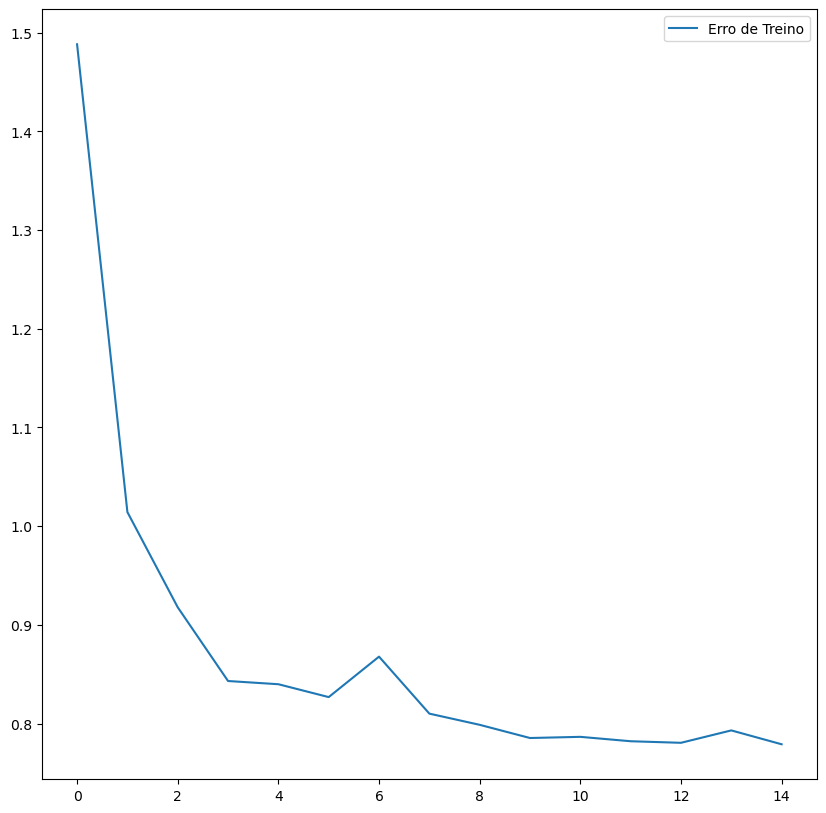

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(loss_per_epoch, label='Erro de Treino')
plt.legend()
plt.show()

In [ ]:
digits = [i for i in np.arange(10)]
tensor_digits = []
n_dl = DataLoader(mnist_trainset,batch_size= 1)
for d in digits:
     for  i, (X,y) in enumerate(n_dl):
        if int(y) == d:
            tensor_digits.append(X.view(X.shape[0],IMPUT_DIM))
            break
    


 Para cada digito existente no conjunto gera uma amostra dentro da distribuição e utiliza a função decode para transformar essa amostra em uma imagem do dígito representado 

In [ ]:
from torchvision.utils import save_image
i = 0
path = r"C:\Users\Felipe\Desktop\Projetos Pessoais\Imagens geradas Mnist"
for item in tensor_digits: 
   with torch.no_grad():
        mu,sigma = model.encode(item)
        eps = torch.rand_like(sigma)
        z = mu + sigma*eps
        out = model.decode(z)
        out = torch.reshape(out,(1,28,28))
        img_name = f'\Digito_{i}_gerado.png'
        i+=1
        concat = path.join(img_name)
        save_image(out,path+f'\ {img_name}')
